In [1]:
#========================================================================
#
# Name: Seoul-bike-hire-data.ipynb
#
# Date: 20/05/2025
#
# Author: MT
# 
# Description: Bike Hire Demand Prediction
# https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand
#
# Steps:
# Step 0: Imports and Locations
# Step 1: Read Data
# Step 2: Prepare Data
# Step 3: Response Variable
# Step 4: Remove Hours Not Functioning
# Step 5: Time
# Step 6: Weather


#
#========================================================================

In [2]:
#========================================================================
# Step 0: Imports and Locations

# Imports
import pandas as pd
import numpy as np
import copy
pd.set_option('display.max_columns', 500) # 10000 columns
pd.set_option('display.max_rows', 500) # 10000 rows

# Seaborn
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", font_scale=1.2)

# Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

# XGBoost
from xgboost import XGBRegressor
import xgboost

# SHAP Explainability
import shap
shap.initjs()

# Model Performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score

# Data
from ucimlrepo import fetch_ucirepo 

#------------------------;
def root_mean_squared_error_group(y_true=None, y_pred=None, group=None):
    """
    Calculate RMSE for each group
    """
    levels=group.unique()
    values=[]
    for this_level in levels:
        this_y_true=y_true[group==this_level]
        this_y_pred=y_pred[group==this_level]
        values.append(root_mean_squared_error(y_true=this_y_true, y_pred=this_y_pred))
    return pd.DataFrame({'group':levels, 'RMSE':values})
#------------------------;

#------------------------;
def r2_score_group(y_true=None, y_pred=None, group=None):
    """
    Calculate RSQ for each group
    """
    levels=group.unique()
    values=[]
    for this_level in levels:
        this_y_true=y_true[group==this_level]
        this_y_pred=y_pred[group==this_level]
        values.append(r2_score(y_true=this_y_true, y_pred=this_y_pred))
    return pd.DataFrame({'group':levels, 'RSQ':values})
#------------------------;
#========================================================================

In [3]:
#========================================================================
# Step 1: Read Data
  
# fetch dataset 
seoul_bike_sharing_demand = fetch_ucirepo(id=560)
  
# data (as pandas dataframes) 
X = seoul_bike_sharing_demand.data.features 
y = seoul_bike_sharing_demand.data.targets 
df=pd.concat([y, X], axis=1)

print(df.info())
#========================================================================

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Functioning Day        8760 non-null   object 
 1   Date                   8760 non-null   object 
 2   Rented Bike Count      8760 non-null   int64  
 3   Hour                   8760 non-null   int64  
 4   Temperature            8760 non-null   float64
 5   Humidity               8760 non-null   int64  
 6   Wind speed             8760 non-null   float64
 7   Visibility             8760 non-null   int64  
 8   Dew point temperature  8760 non-null   float64
 9   Solar Radiation        8760 non-null   float64
 10  Rainfall               8760 non-null   float64
 11  Snowfall               8760 non-null   float64
 12  Seasons                8760 non-null   object 
 13  Holiday                8760 non-null   object 
dtypes: float64(6), int64(4), object(4)
memory usage: 958.3+ 

In [4]:
#=================================================================
# Step 2: Prepare Data

# Copy dataframe
df2=copy.deepcopy(df)

# Convert Date to datetime format
df2['DateTime'] = pd.to_datetime(
    df2['Date'] + ' ' + df2['Hour'].astype(str) + ':00',
    format='%d/%m/%Y %H:%M'
)

# Extract Year, Month, and Day of Week from DateTime
df2['Year'] = df2['DateTime'].dt.year
df2['Month'] = df2['DateTime'].dt.month
df2['DayOfWeek'] = df2['DateTime'].dt.strftime('%a')

# Create binary indicators for Rainfall and Snowfall
df2['Rainfall_Indicator']=np.where(df2['Rainfall'] == 0, 0, 1)
df2['Snowfall_Indicator']=np.where(df2['Snowfall'] == 0, 0, 1)
#=================================================================

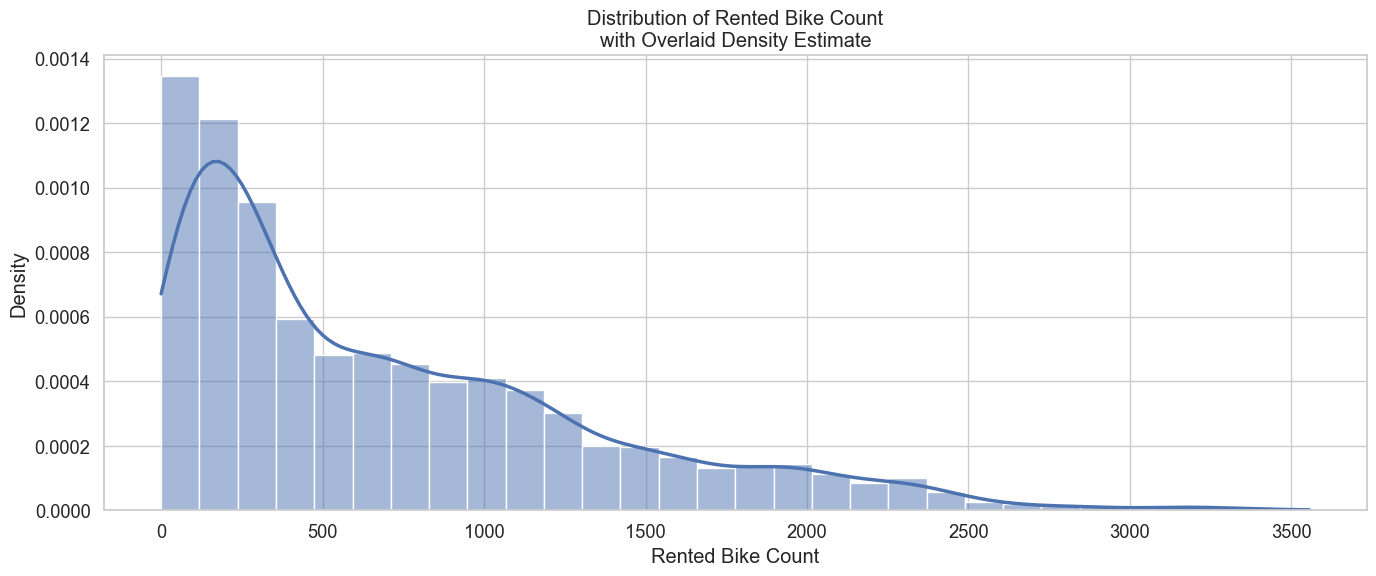

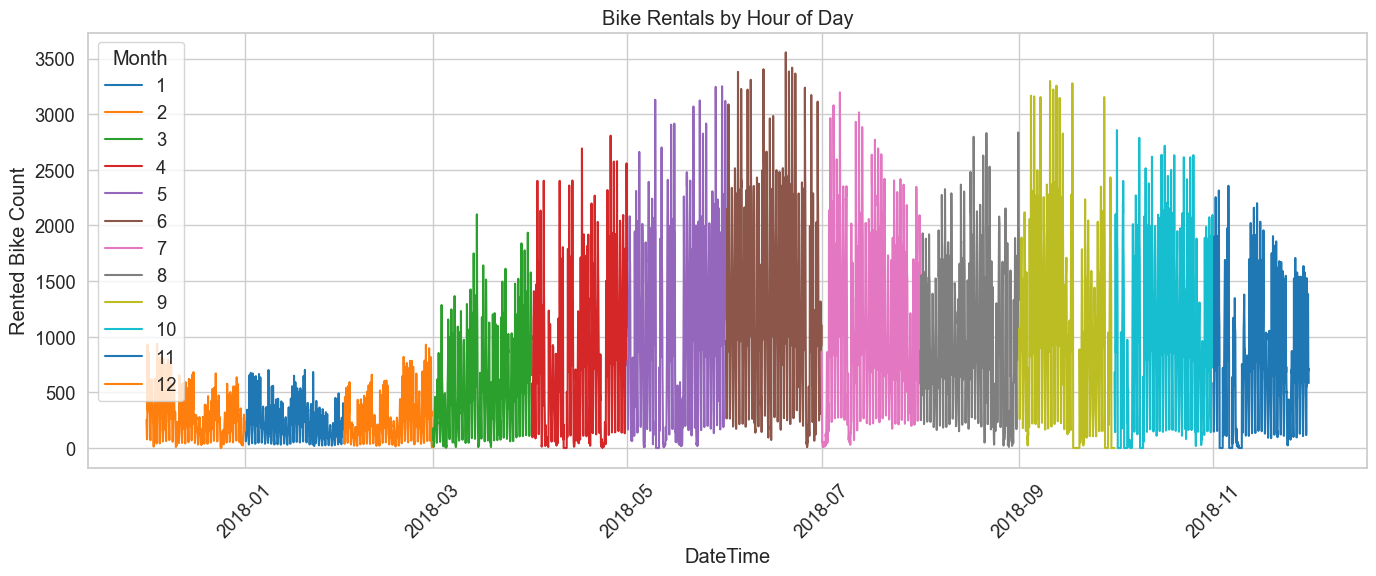

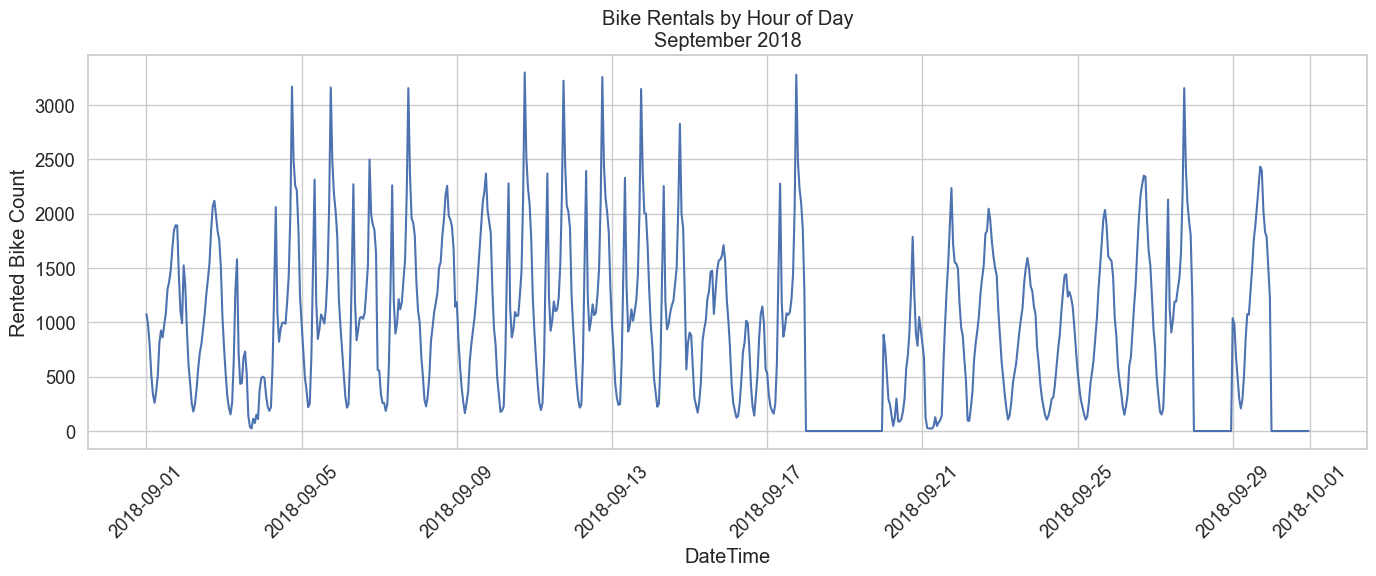

In [5]:
#=================================================================
# Step 3: Response Variable

# Histogram of Rented Bike Count
plt.figure(figsize=(14, 6)) 
sns.histplot(data=df2, x='Rented Bike Count', bins=30, kde=True, stat='density', line_kws={'linewidth': 2.5})
plt.title('Distribution of Rented Bike Count\nwith Overlaid Density Estimate')
plt.xlabel('Rented Bike Count')
plt.ylabel('Density')
plt.tight_layout()  
plt.savefig("seoul-bike-hire-count-histogram.png", dpi=300)
plt.show()

# Overall plot
plt.figure(figsize=(14, 6)) 
sns.lineplot(
    data=df2,
    x='DateTime',
    y='Rented Bike Count',
    hue='Month',
    palette='tab10',
    legend='full',
)
plt.xticks(rotation=45)
plt.title('Bike Rentals by Hour of Day')
plt.xlabel('DateTime')
plt.ylabel('Rented Bike Count')
plt.tight_layout()  
plt.savefig("seoul-bike-hire-count-hour.png", dpi=300)
plt.show()

# Plot for September
plt.figure(figsize=(14, 6)) 
sns.lineplot(
    data=df2[df2['Month']==9],
    x='DateTime',
    y='Rented Bike Count',
    legend='full',
)
plt.xticks(rotation=45)
plt.title('Bike Rentals by Hour of Day\nSeptember 2018')
plt.xlabel('DateTime')
plt.ylabel('Rented Bike Count')
plt.tight_layout()  
plt.savefig("seoul-bike-hire-count-hour-september.png", dpi=300)
plt.show()
#=================================================================

In [6]:

# Plot for 1st -7th September
mask1=df2['Month']==9
mask2=pd.to_datetime(df2['Date'], dayfirst=True)<=pd.to_datetime('7/9/2018', dayfirst=True)
plt.figure(figsize=(14, 6)) 
sns.lineplot(
    data=data,
    x='DateTime',
    y='Rented Bike Count',
    hue='DayOfWeek',
    legend='full',
)
plt.xticks(rotation=45)
plt.title('Bike Rentals by Hour of Day\n1st-7th September 2018')
plt.xlabel('DateTime')
plt.ylabel('Rented Bike Count')
plt.tight_layout()  
plt.savefig("seoul-bike-hire-count-hour-september-1st-7th.png", dpi=300)
plt.show()


NameError: name 'data' is not defined

<Figure size 1400x600 with 0 Axes>

In [ ]:
#=================================================================
# Step 4: Remove Hours Not Functioning
df3 = copy.deepcopy(df2[df2['Functioning Day']=='Yes'])
print(df2['Functioning Day'].value_counts())

# Columns to keep
cols=['Rented Bike Count', 'Seasons', 'Holiday', 'Month', 'DayOfWeek','Hour', 
'Temperature','Humidity','Wind speed', 'Visibility', 'Dew point temperature', 'Solar Radiation', 
'Rainfall_Indicator', 'Snowfall_Indicator']
df3 = df3[cols]
#=================================================================

Functioning Day
Yes    8465
No      295
Name: count, dtype: int64


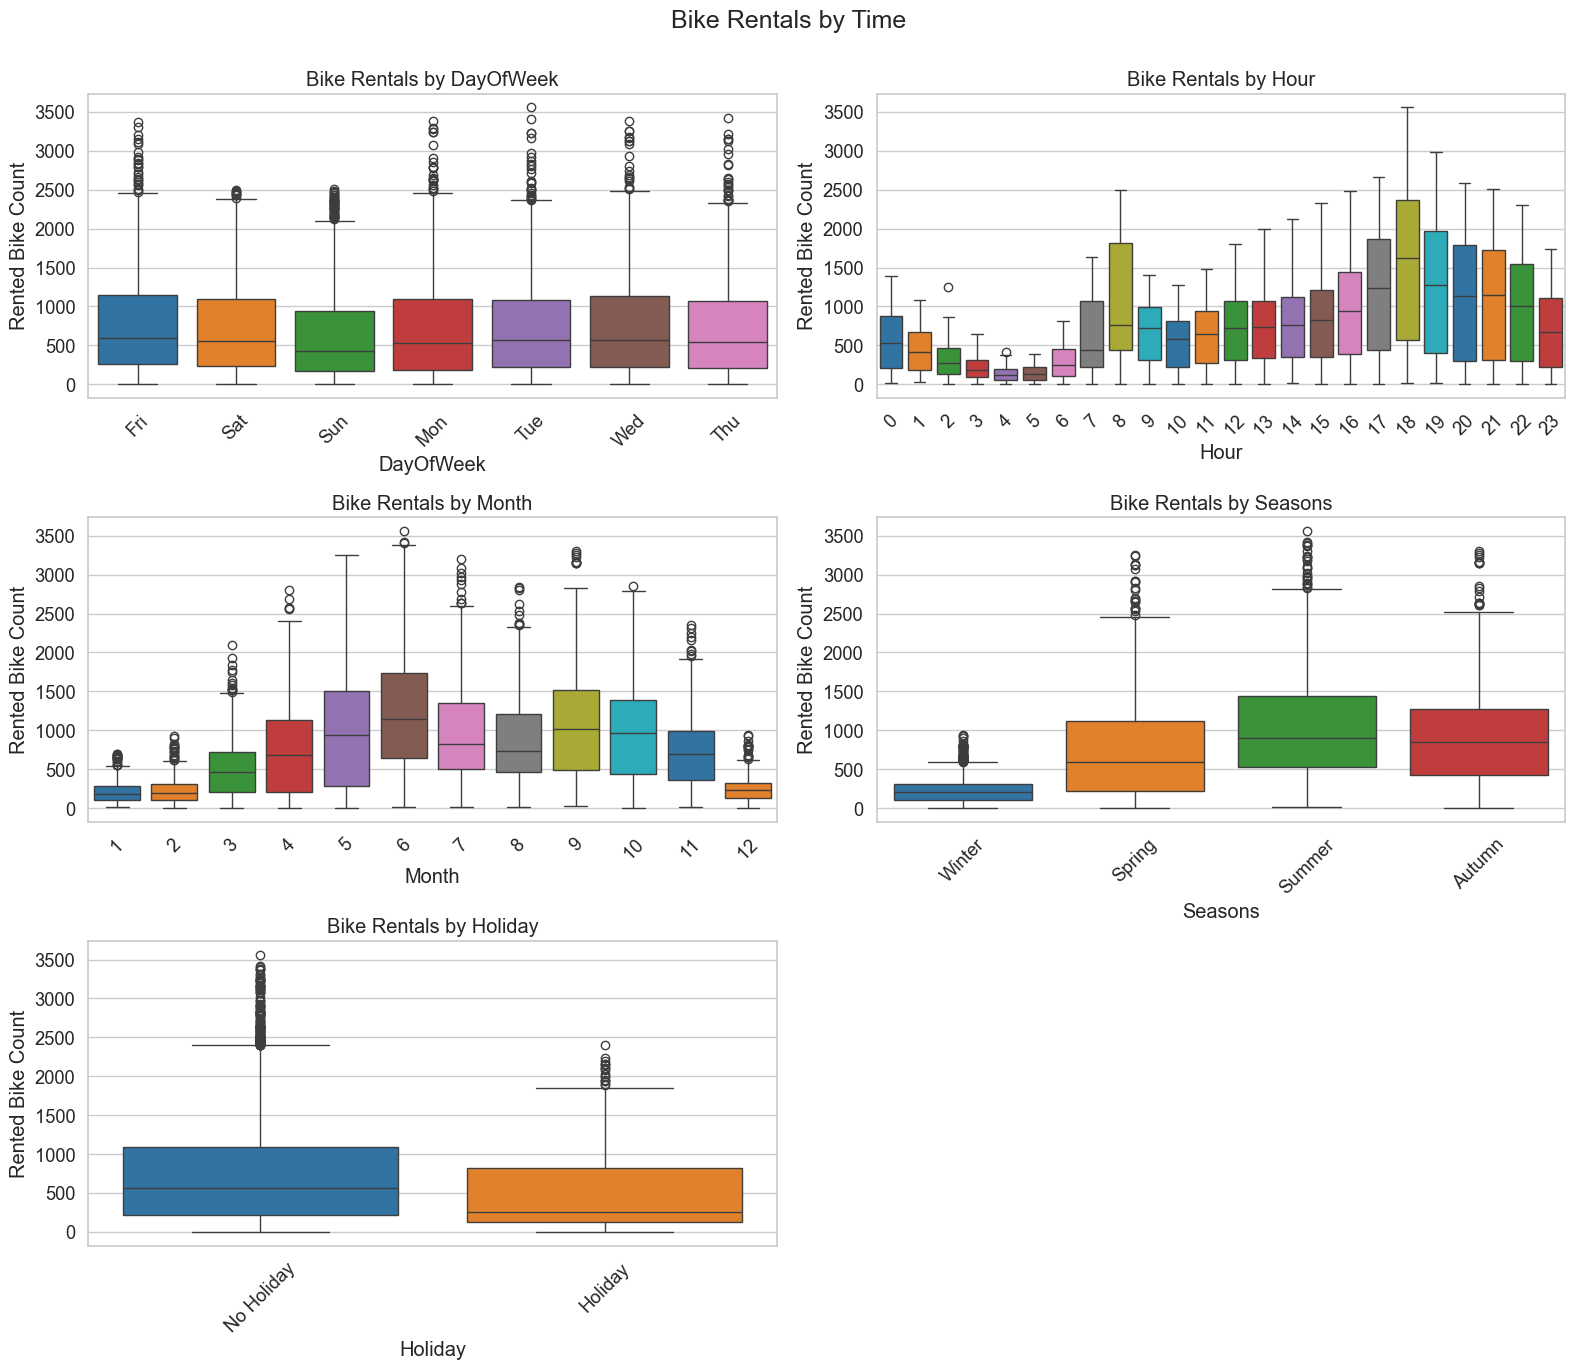

In [ ]:
#=================================================================
# Step 5: Time

# Variables to plot
vars_to_plot = ['DayOfWeek', 'Hour', 'Month', 'Seasons', 'Holiday']

# Create 3x2 grid (6 subplots)
fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# Flatten axes for easy iteration
axes = axes.flatten()

# Loop through variables and axes
for ax, thisVar in zip(axes, vars_to_plot):
    sns.boxplot(
        data=df3,
        x=thisVar,
        y='Rented Bike Count',
        hue=thisVar,
        palette='tab10',
        ax=ax
    )
    ax.set_title(f'Bike Rentals by {thisVar}')
    ax.set_xlabel(thisVar)
    ax.set_ylabel('Rented Bike Count')
    ax.tick_params(axis='x', rotation=45)
    leg = ax.get_legend()
    if leg is not None:
        leg.remove()

# Hide the unused 6th subplot (last one stays blank)
axes[-1].set_visible(False)

fig.suptitle("Bike Rentals by Time", fontsize=18)
fig.tight_layout()  
fig.subplots_adjust(top=0.92)
plt.savefig("seoul-bike-hire-features-time.png", dpi=300, bbox_inches="tight")
plt.show()
#=================================================================

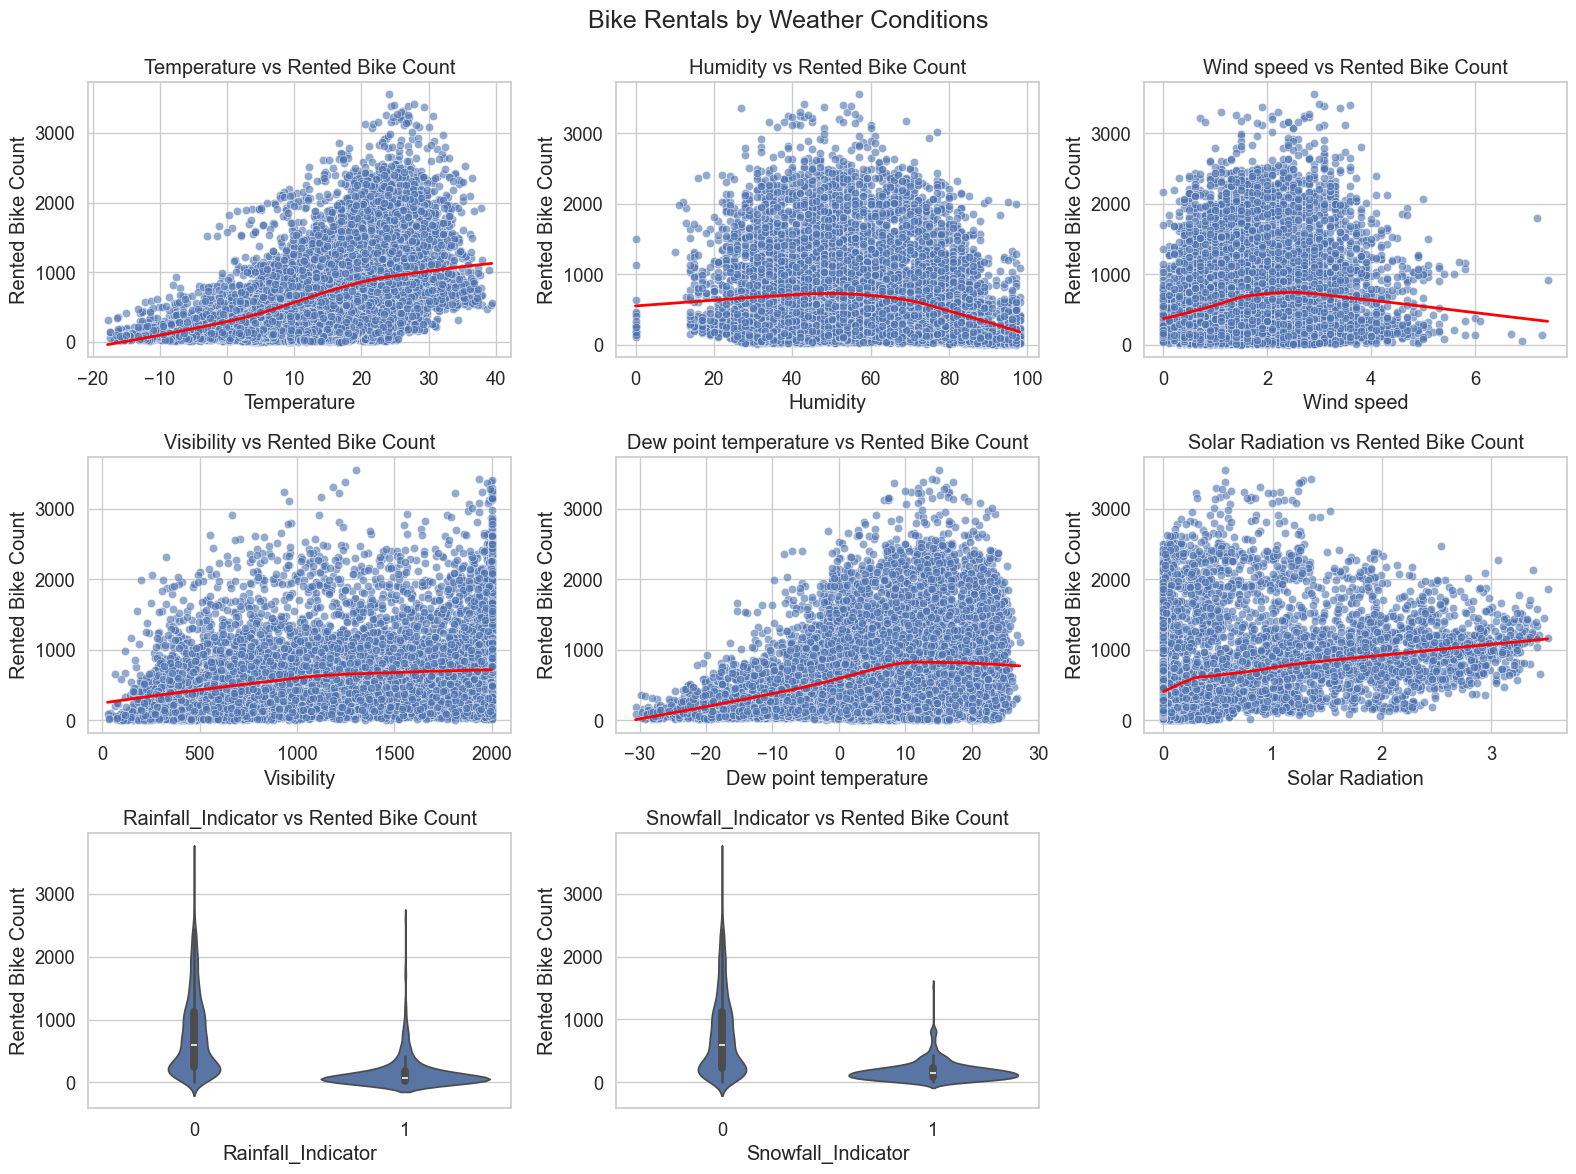

In [ ]:
#=================================================================
# Step 6: Weather

# Variables of interest
vars = ['Temperature', 'Humidity', 'Wind speed', 'Visibility',
        'Dew point temperature', 'Solar Radiation',
        'Rainfall_Indicator', 'Snowfall_Indicator']

# Create 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for i, var in enumerate(vars):
    ax = axes[i]

    if var in ['Rainfall_Indicator', 'Snowfall_Indicator']:
        # --- Boxplot for indicators ---
        sns.violinplot(
            data=df3,
            x=var,
            y='Rented Bike Count',
            ax=ax,
        )
    else:
        # --- Scatter + LOESS for continuous variables ---
        sns.scatterplot(
            data=df3,
            x=var,
            y='Rented Bike Count',
            alpha=0.6,
            ax=ax
        )
        sns.regplot(
            data=df3,
            x=var,
            y='Rented Bike Count',
            scatter=False,
            lowess=True,
            ax=ax,
            line_kws={"color": "red", "lw": 2}
        )

    # Labels & title
    ax.set_title(f"{var} vs Rented Bike Count")
    ax.set_xlabel(var)
    ax.set_ylabel("Rented Bike Count")

# Hide unused subplots
for j in range(len(vars), len(axes)):
    axes[j].set_visible(False)

# Overall title
fig.suptitle("Bike Rentals by Weather Conditions", fontsize=18)
fig.tight_layout()  
fig.subplots_adjust(top=0.92)
plt.savefig("seoul-bike-hire-features-weather.png", dpi=300, bbox_inches="tight")
plt.show()
#=================================================================

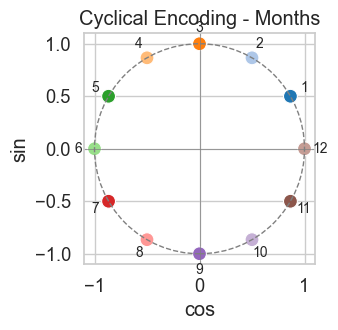

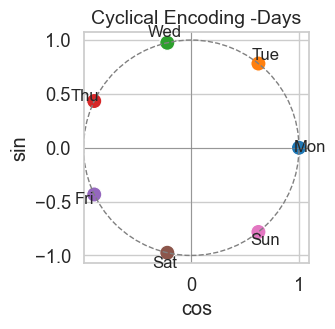

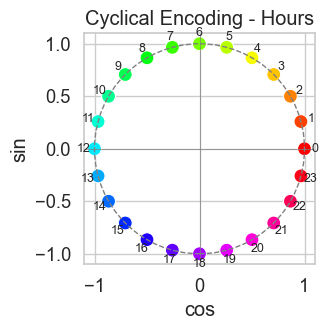

In [ ]:
#=================================================================
# Step 7: Cyclical Encoding

#-------
# Cyclical Encoding of Months of the Year# Months of the year (1–12)
months = np.arange(1, 13)

# Cyclical encoding
N = 12
month_sin = np.sin(2 * np.pi * months / N)
month_cos = np.cos(2 * np.pi * months / N)

# Put into DataFrame
df_months = pd.DataFrame({
    "month": months,
    "sin": month_sin,
    "cos": month_cos
})

# Plot
plt.figure(figsize=(3,3))
sns.scatterplot(data=df_months, x="cos", y="sin", hue="month", palette="tab20", s=100)

# Annotate months (no decimals)
for i, row in df_months.iterrows():
    plt.text(row["cos"]*1.15, row["sin"]*1.15, str(int(row["month"])),
             ha='center', va='center', fontsize=10)

# Add unit circle
circle = plt.Circle((0,0), 1, color="gray", fill=False, linestyle="--")
plt.gca().add_patch(circle)

plt.axhline(0, color="gray", linewidth=0.5)
plt.axvline(0, color="gray", linewidth=0.5)
plt.gca().set_aspect("equal", adjustable="box")
plt.legend().remove()
plt.title("Cyclical Encoding - Months")
plt.savefig("seoul-bike-hire-features-cyclic-months.png", dpi=300, bbox_inches="tight")
plt.show()
#-------

#-------
# Cyclical Encoding of Days of the Week
# Redefine variables since this is a new cell
days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
day_nums = np.arange(len(days))  # 0-6

# Cyclical encoding
N = 7
day_sin = np.sin(2 * np.pi * day_nums / N)
day_cos = np.cos(2 * np.pi * day_nums / N)

# Create DataFrame
df_days = pd.DataFrame({
    "day": days,
    "cos": day_cos,
    "sin": day_sin
})

# Seaborn scatter plot
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(3,3))
sns.scatterplot(data=df_days, x="cos", y="sin", hue="day", palette="tab10", s=120)

# Annotate
for i, row in df_days.iterrows():
    plt.text(row["cos"]*1.1, row["sin"]*1.1, row["day"], 
             ha='center', va='center', fontsize=12)

# Circle and axes
circle = plt.Circle((0,0), 1, color="gray", fill=False, linestyle="--")
plt.gca().add_patch(circle)
plt.axhline(0, color="gray", linewidth=0.5)
plt.axvline(0, color="gray", linewidth=0.5)
plt.legend().remove()
plt.gca().set_aspect("equal", adjustable="box")
plt.title("Cyclical Encoding - Days", fontsize=14)
plt.savefig("seoul-bike-hire-features-cyclic-days.png", dpi=300, bbox_inches="tight")
plt.show()
#-------

#-------
# Cyclical Encoding of Hours of the Day# Hours of the day (0–23)
hours = np.arange(24)

# Cyclical encoding
N = 24
hour_sin = np.sin(2 * np.pi * hours / N)
hour_cos = np.cos(2 * np.pi * hours / N)

# Put in DataFrame for plotting
df_hours = pd.DataFrame({
    "hour": hours,
    "sin": hour_sin,
    "cos": hour_cos
})

# Plot on circle
plt.figure(figsize=(3,3))
sns.scatterplot(data=df_hours, x="cos", y="sin", hue="hour", palette="hsv", s=100)

# Annotate points
for i, row in df_hours.iterrows():
    plt.text(row["cos"]*1.1, row["sin"]*1.1, f"{int(row['hour'])}",
             ha='center', va='center', fontsize=9)

# Add unit circle
circle = plt.Circle((0,0), 1, color="gray", fill=False, linestyle="--")
plt.gca().add_patch(circle)

plt.axhline(0, color="gray", linewidth=0.5)
plt.axvline(0, color="gray", linewidth=0.5)
plt.gca().set_aspect("equal", adjustable="box")
plt.legend().remove()
plt.title("Cyclical Encoding - Hours")
plt.savefig("seoul-bike-hire-features-cyclic-hours.png", dpi=300, bbox_inches="tight")
plt.show()
#-------
#=================================================================

In [ ]:
#=================================================================
# Step 6: Prepare for Modelling

df4=copy.deepcopy(df3)

# Cyclical encoding DayOfWeek (7 days in a week)
N = 7
day_map = {"Mon": 0, "Tue": 1, "Wed": 2, "Thu": 3, "Fri": 4, "Sat": 5, "Sun": 6}
df4["DayOfWeek_num"] = df4["DayOfWeek"].map(day_map)
df4["DayOfWeek_sin"] = np.sin(2 * np.pi * df4["DayOfWeek_num"] / N)
df4["DayOfWeek_cos"] = np.cos(2 * np.pi * df4["DayOfWeek_num"] / N)

df4[['DayOfWeek_num','DayOfWeek_sin','DayOfWeek_cos']].head(10)


# Compute back the day index (0=Mon ... 6=Sun)
angles = np.arctan2(df4["DayOfWeek_sin"], df4["DayOfWeek_cos"])
day_idx = (np.round(angles / (2*np.pi) * 7) % 7).astype(int)
pd.crosstab(df4["DayOfWeek_num"], day_idx, rownames=['Original'], colnames=['Computed'])

Computed,0,1,2,3,4,5,6
Original,,,,,,,
0,1248,0,0,0,0,0,0
1,0,1152,0,0,0,0,0
2,0,0,1200,0,0,0,0
3,0,0,0,1200,0,0,0
4,0,0,0,0,1224,0,0
5,0,0,0,0,0,1217,0
6,0,0,0,0,0,0,1224


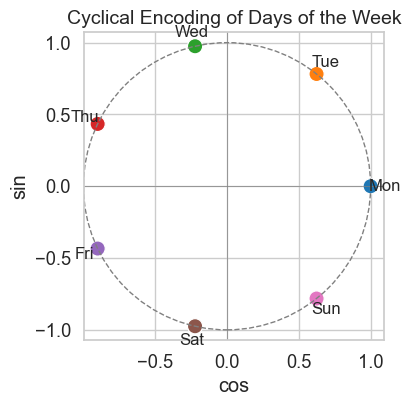

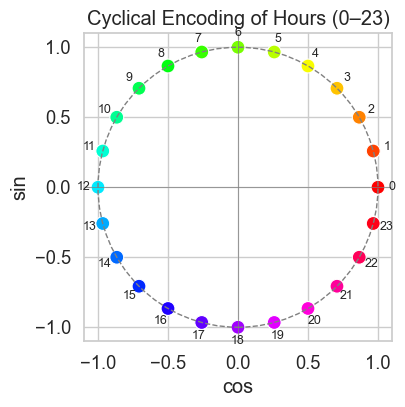